# The Optimal Asshole Portfolio

## Aim of project and underlying assumptions:

The aim of this project is to find the optimal portfolio combination of the following stocks:
- RCI Hospitality Holdings Inc (RICK)
- Philip Morris International (PM)
- AeroVironment, Inc. (AVAV)
- Ferrari N.V. (RACE)
- Las Vegas Sands (LVS)
- Canopy Growth (CGC)
- Tiffany & Co. (TIF)
- Tesla Motors (TSLA)

To find the optimal portfolio, we take an offset in Modern Portfolio Theory, finding the portfolio combination that bears the lowest risk i.e. the Minimum Variance Portolio (MVP).  To find the optimal portfolio, we furthermore make use of the Capital Asset Pricing Model (CAPM), which ultimately gives us the portfolio with the optimal ratio between expected return and risk i.e where we maximze the sharpe-ratio.  

In our model we make the following assumptions: 

- Investors are rational and risk-averse. 
- Historical returns is representative for future returns.
- Investors are price takers, meaning they cannot influence future prices.
- No transaction cost
- Investors can lend and borrow unlimited at the same risk free rate

Lastly we assume 253 trading days a year, and look at data from january 1st 2010 untill january 1st 2020 to make our estimations. Therfore our results will be showing the optimal portfolio per January 1st 2020. 





In [434]:
## packages and imports
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.stats as scs
import scipy.optimize as sco
import statsmodels.api as sm
import scipy.interpolate as sci
from pandas_datareader import data as pdr
import yfinance as yf

First we get all data into the file, and use the dividend-adjusted closing prices as the closing price for a given stock

In [440]:
# Time period and stocks: 
start_date = datetime.datetime(2010,1,1)
end_date = datetime.datetime(2020,1,1)
sym = ["RICK","PM","AVAV", "RACE","LVS","CGC","TIF","TSLA"]
stocks = len(sym)

# get data as dataframe:
yf.pdr_override() 
data = pdr.get_data_yahoo(sym, start=start_date, end=end_date)["Adj Close"]
data.iloc[np.r_[0:2, -2:0]]

[*********************100%***********************]  8 of 8 completed


,AVAV,CGC,LVS,PM,RACE,RICK,TIF,TSLA
Date,,,,,,,,
2010-01-04,29.610001,NaN,11.084208,30.519670,NaN,8.870609,35.935379,NaN
2010-01-05,29.000000,NaN,12.184628,30.253746,NaN,9.083891,36.172279,NaN
2019-12-30,62.779999,18.790001,67.944542,84.190605,164.142273,20.273634,132.783920,414.700012
2019-12-31,61.740002,21.090000,67.689629,83.591347,164.380569,20.453224,132.953033,418.329987


Secondly we calculate daily returns as todays adj. closing price divided by yesterdays adj. closing price. We take the natural logarithm of this to show returns in percentage.

In [445]:
# Calculate log daily returns

log_daily_return = np.log(data / data.shift(1))
log_daily_return.iloc[np.r_[0:2, -2:0]]


,AVAV,CGC,LVS,PM,RACE,RICK,TIF,TSLA
Date,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.020816,NaN,0.094654,-0.008751,NaN,0.023759,0.006571,NaN
2019-12-30,0.011696,-0.022106,-0.006329,-0.007093,-0.020479,0.014374,-0.002245,-0.037113
2019-12-31,-0.016704,0.115474,-0.003759,-0.007143,0.001451,0.008819,0.001273,0.008715


Now we plot cumulative returns, which shows us the performance of each individuals stock from 2010 to 2020. 

Text(0,0.5,'Cumulative return, in %')

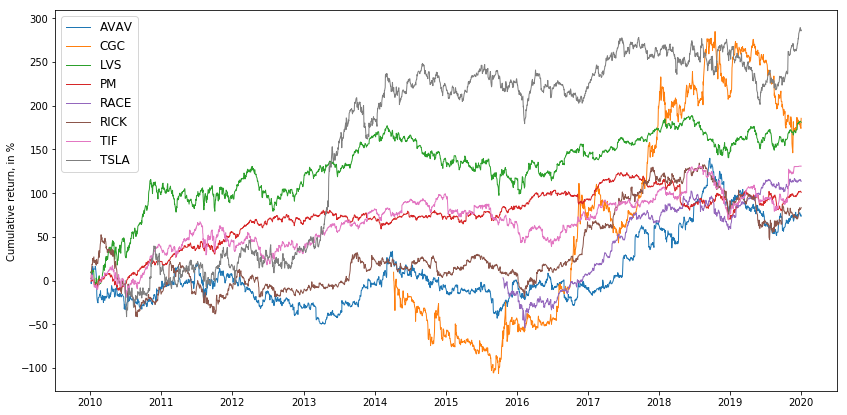

In [450]:
# log returns to avoid compound effect

################################################################

# stock performance
# evt kombinér stock performance + daily returns 

Performance = log_daily_return.cumsum() * 100
Performance.iloc[np.r_[0:2, -2:0]]


plt.figure(figsize=(14, 7))
for x in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, Performance[x], lw=1, alpha=1, label=x)
plt.legend(fontsize=12)
plt.ylabel('Cumulative return, in %')

Below is the logged daily returns for each shock shown in a simple plot

Text(0,0.5,'Daily returns')

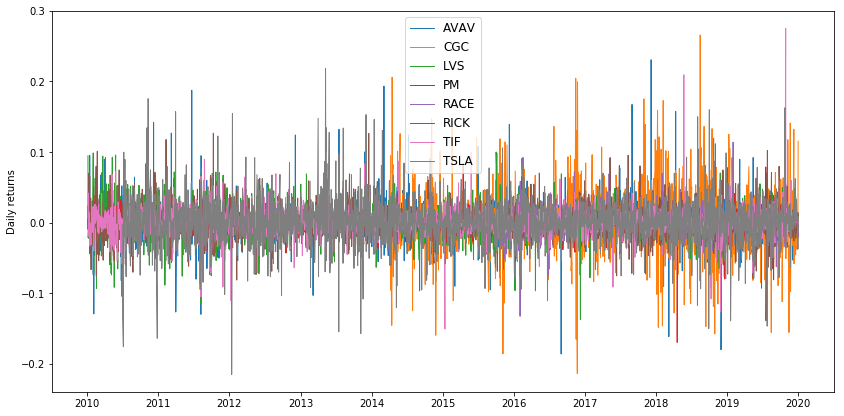

In [455]:
# plot log_daily_returns

plt.figure(figsize=(14, 7))
for c in log_daily_return.columns.values:
    plt.plot(log_daily_return.index, log_daily_return[c],lw=1, alpha=1, label=c)
plt.legend(fontsize=12)
plt.ylabel('Daily returns')

To find the expected returns and their corresponding variances, we calculate average return per year

In [460]:
yearly_trading_days = 253

# Mean returns, YoY

Avg_return = log_daily_return.mean() * yearly_trading_days



Based on our annual returns, we create a covariance matrix showing how each stock covariate meaning how one stocks react to a change of the price of another stock.

In [465]:
# Covariance Matrix with mean return

CovMatrix = log_daily_return.cov() * yearly_trading_days
CovMatrix['Mean'] = Avg_return
CovMatrix['Mean'] = pd.Series(["{0:.2f}%".format(val*100) for val in CovMatrix['Mean']],index = CovMatrix.index)
CovMatrix

,AVAV,CGC,LVS,PM,RACE,RICK,TIF,TSLA,Mean
AVAV,0.161190,0.017369,0.031458,0.013397,0.023851,0.024086,0.033527,0.035864,7.39%
CGC,0.017369,0.504169,0.024120,0.006947,0.022110,0.004618,0.016232,0.023991,32.50%
LVS,0.031458,0.024120,0.125472,0.018241,0.030962,0.031298,0.047850,0.044943,18.20%
PM,0.013397,0.006947,0.018241,0.037714,0.008870,0.010516,0.015081,0.011950,10.14%
RACE,0.023851,0.022110,0.030962,0.008870,0.087745,0.017973,0.024020,0.037597,27.23%
RICK,0.024086,0.004618,0.031298,0.010516,0.017973,0.113734,0.023550,0.028537,8.40%
TIF,0.033527,0.016232,0.047850,0.015081,0.024020,0.023550,0.094379,0.038307,13.16%
TSLA,0.035864,0.023991,0.044943,0.011950,0.037597,0.028537,0.038307,0.263141,30.27%


Weight

In [470]:
weights = np.random.random(stocks)
weights /= np.sum(weights)
weights.sum()


1.0

We now calculate the Expected return

In [475]:
np.sum(log_daily_return.mean() * weights) * 253

0.17483805883978948

The Variance is calculated

In [480]:

np.dot(weights.T, np.dot(log_daily_return.cov() * 253, weights))

0.03837392271514956

Finally the Standard Deviation is calculated before we can go into our Monte Carlo Simulation

In [485]:
np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * 253, weights)))

0.1958926305789719

Simulation of portolio using Monte Carlo.

In [429]:
portfolio_return = [] 
portfolio_variance = [] 

for p in range (10000):
 
 weights = np.random.random(stocks)
 weights /= np.sum(weights)
 
 portfolio_return.append(np.sum(log_daily_return.mean() * weights) * 253)

 portfolio_variance.append(np.sqrt(np.dot(weights.T, np.dot(log_daily_return.cov() * 253, weights))))


portfolio_return = np.array(portfolio_return)
portfolio_variance = np.array(portfolio_variance)

Plotting all possible combinations of our portfolio

Text(0,0.5,'Expected Return of Portfolio')

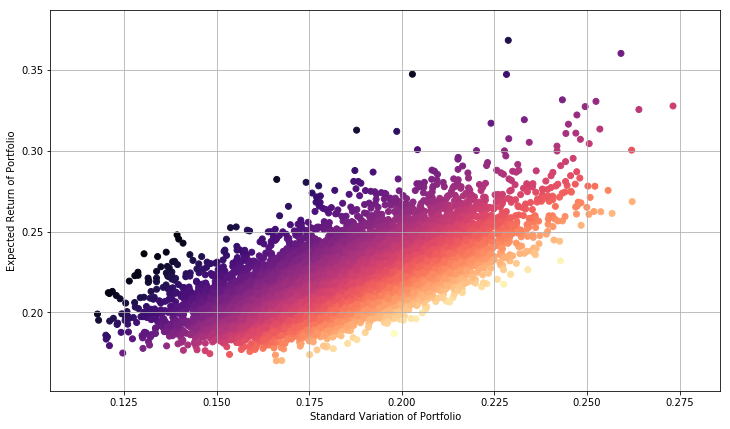

In [435]:
plt.figure(figsize=(12, 7))
plt.scatter(portfolio_return, portfolio_variance, c = portfolio_return / portfolio_variance, marker='o', cmap='magma')

plt.grid(True)
plt.xlabel('Standard Variation of Portfolio')
plt.ylabel('Expected Return of Portfolio')